In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime
import os

ARIMA - Autoregressive intergrated moving averages.


The time variable/feature is the independent variable and supports the target variable to predict the results. To estimate the target variable in the name of predicting or forecasting, use the time variable as the point of reference. A time series is nothing but a sequence of various data points that occurred in a successive order for a given period of time

The general process for ARIMA models is the following:
- visualize the time series data
- make the time series data stationary 
- plot the correlation and autocorrelation charts
- construct the ARIMA model or seasonal ARIMA based on the data
- use the model to make predictions

In [ ]:
from statsmodels.tsa.stattools import adfuller#test for stationary

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [7]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
# Importing store data
# store = pd.read_csv('./data/store.csv')
# store.head()

In [6]:
store = pd.read_csv('/content/drive/MyDrive/store.csv')

This data is Rossman Store's sales data with values related promotion, and competitor data.It is a time series data with equally spaced time intervals (daily, weekly, monthly, yearly). It has observations of sales data over the year of approximately 2 years (2013-2015).

In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [33]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

The 'competitionDistance' column has only 3 values missing, so it's safe to replace those missing values with the median value. We can't use the same approach with competition's existence (month and year) as it doesn't make sense. It is better to replace it with 0 (i.e launched recently). So, it will also be imputed with 0.

In [8]:
train = pd.read_csv('/content/drive/MyDrive/train.csv', index_col='Date', parse_dates = True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [35]:
# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [36]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [9]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

The time or the date here influences sales and it acts as an independent variable.

In [10]:
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


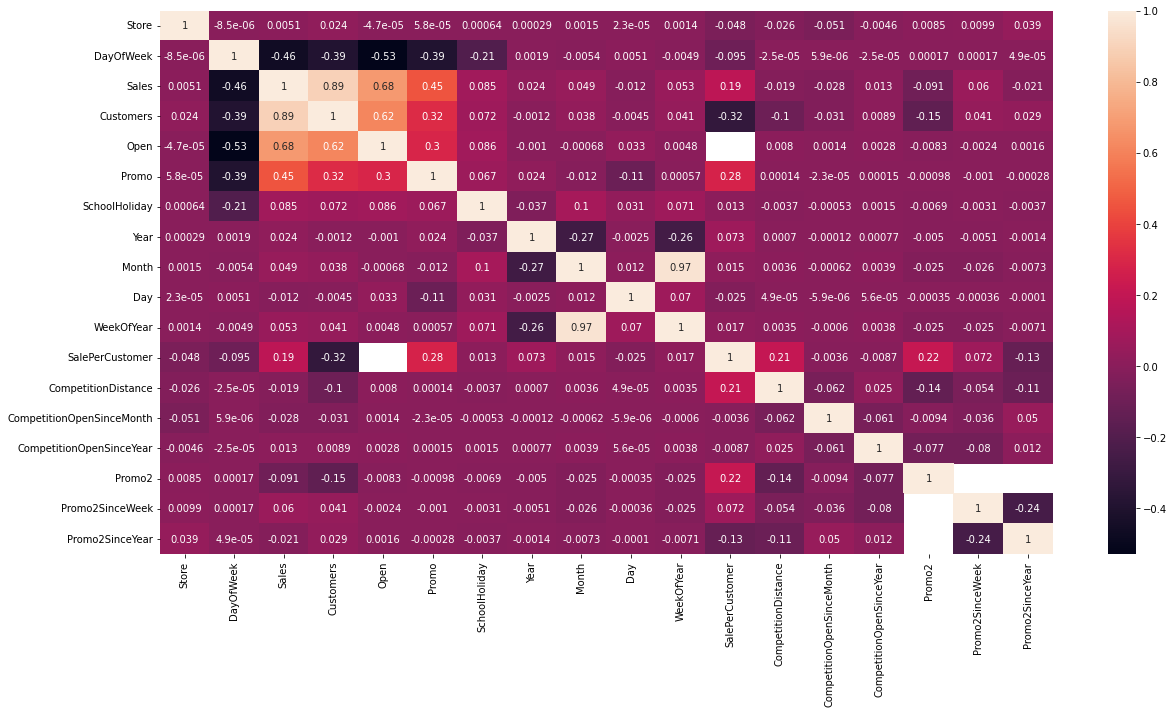

In [12]:
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True);

There is a strong correlation between the amount of Sales and Customers visiting the store, also with (Promo = 1) and number of customers.

Let’s see how the sales vary with month, promo, promo2 (second promotional offer) and year.

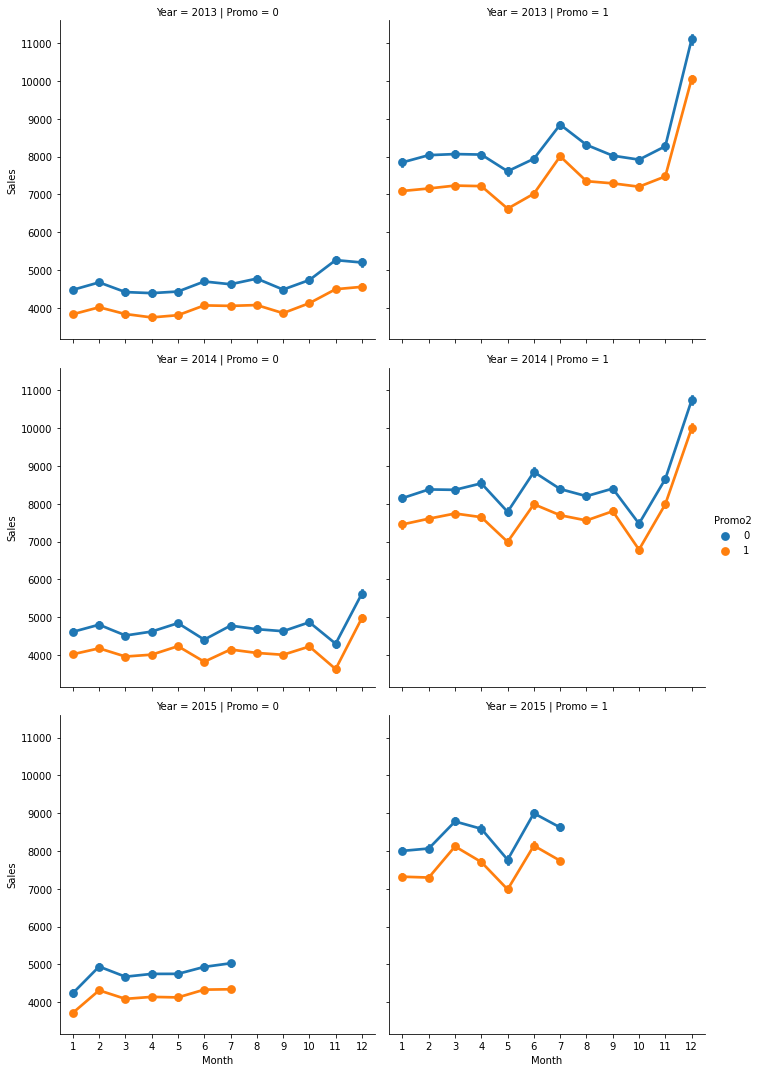

In [11]:
# Sales trend over the months and year
sns.factorplot(data = train_store_joined, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")

###**Insights from EDA**

a) The most selling and crowded StoreType is A.

b) StoreType B has the highest Sale per Customer.

c) Customers tends to buy more on Mondays when there are ongoing promotional offers and on Thursdays/Fridays when there is no promotion at all.

d) Second promotion (Promo2) doesn't seem to contribute in the increase of sales.

e) There is seasonality present in the data as sales tend to increase in November and December.

In [ ]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [ ]:
train_store_joined.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
pd.plotting.register_matplotlib_converters()

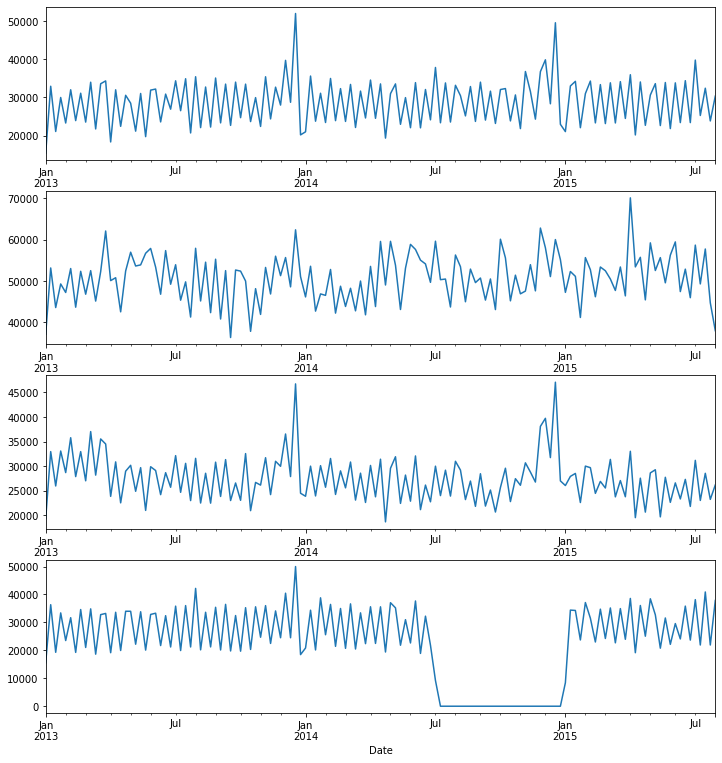

In [15]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

The graphs above show that sales for StoreType A and C tend to peak in the end of year (Christmas season) and then decline after the holidays. We are not able to see a similar trend in StoreType D because no data is available for that time period (stores closed).

## **Stationarity of Time Series**


In [16]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

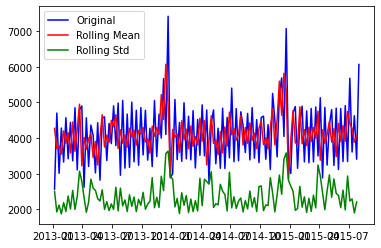

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [17]:
# Testing stationarity of store type a
test_stationarity(sales_a)

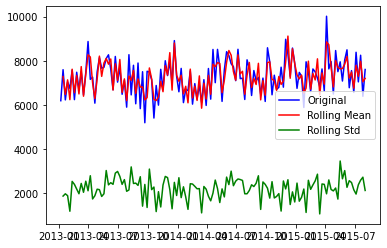

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [19]:
test_stationarity(sales_b)

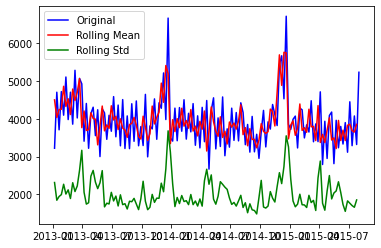

Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [18]:
#Testing stationarity of store type b
test_stationarity(sales_c)

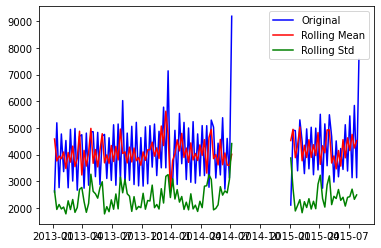

Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [20]:
#Testing stationarity of store type d
test_stationarity(sales_d)

We can see from the above plots and statistical tests that mean and variation doesn't change much with time, i.e they are constant. Thus, we don't need to perform any transformation (needed when time series is not stationary).



### **Trend and seasonality**

In [21]:
# Plotting seasonality and trend
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

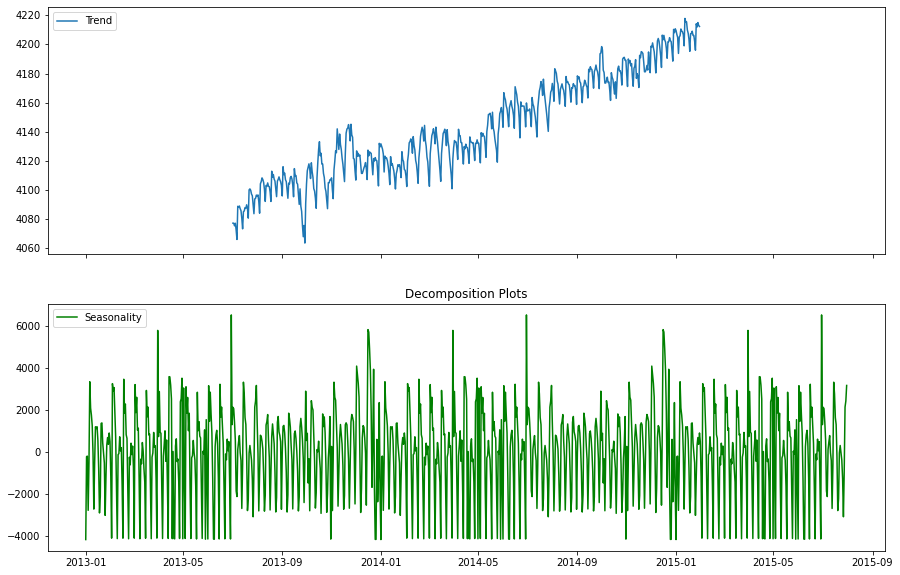

In [22]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

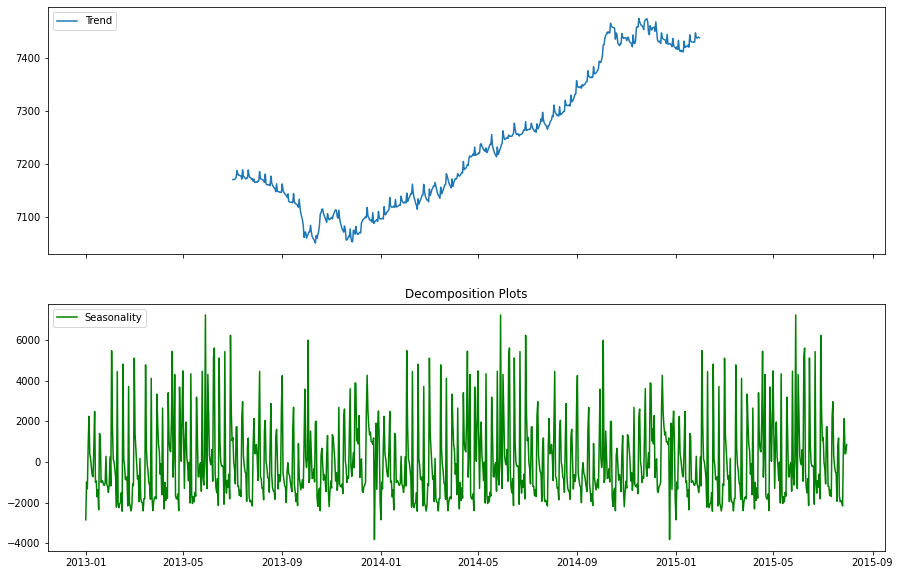

In [23]:
# Plotting seasonality and trend for store type b
plot_timeseries(sales_b,'b')

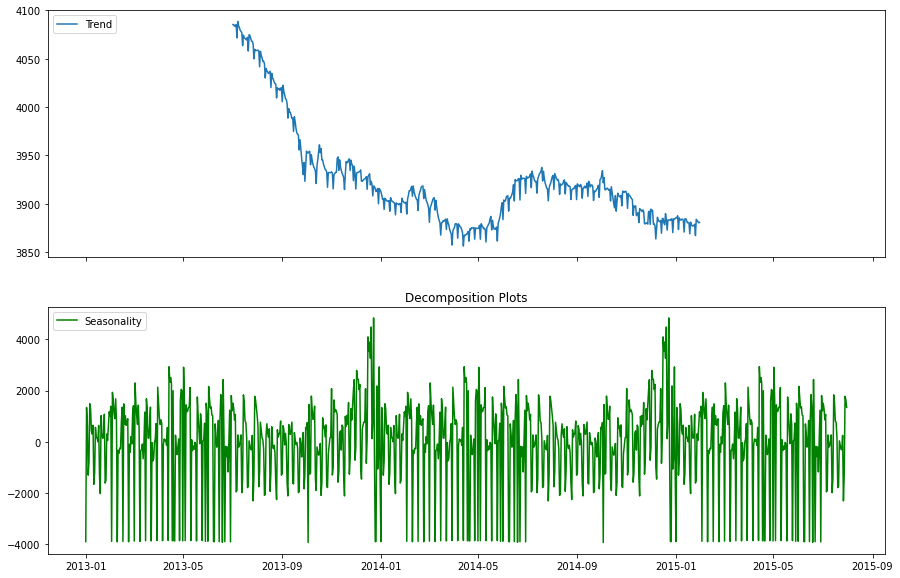

In [24]:
# Plotting seasonality and trend for store type c
plot_timeseries(sales_c,'c')

From the above plots, we can see that there is seasonality and trend present in our data. So, we'll use forecasting models that take both of these factors into consideration.

In [25]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)

In [26]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [27]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [28]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20) 

In [29]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[08:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5164.37	eval-rmse:5165.86
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:4012.86	eval-rmse:4011.4
[2]	train-rmse:3293.48	eval-rmse:3287.77
[3]	train-rmse:2870.49	eval-rmse:2863.65
[4]	train-rmse:2629.58	eval-rmse:2622.12
[5]	train-rmse:2500.65	eval-rmse:2492.5
[6]	train-rmse:2417.1	eval-rmse:2408.16
[7]	train-rmse:2354.29	eval-rmse:2346.47
[8]	train-rmse:2326.76	eval-rmse:2318.94
[9]	train-rmse:2284.17	eval-rmse:2277.44
[10]	train-rmse:2253.49	eval-rmse:2246.74
[11]	train-rmse:2220.76	eval-rmse:2213.6
[12]	train-rmse:2209.57	eval-rmse:2202.78
[13]	train-rmse:2179.89	eval-rmse:2174.23
[14]	train-rmse:2169.25	eval-rmse:2163.95
[15]	train-rmse:2107.8	eval-rmse:2101.71
[16]	train-rmse:2072.34	eval-rmse:2064.97
[17]	train-rmse:2031.1	eval-rm

In [30]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1209.330230669668


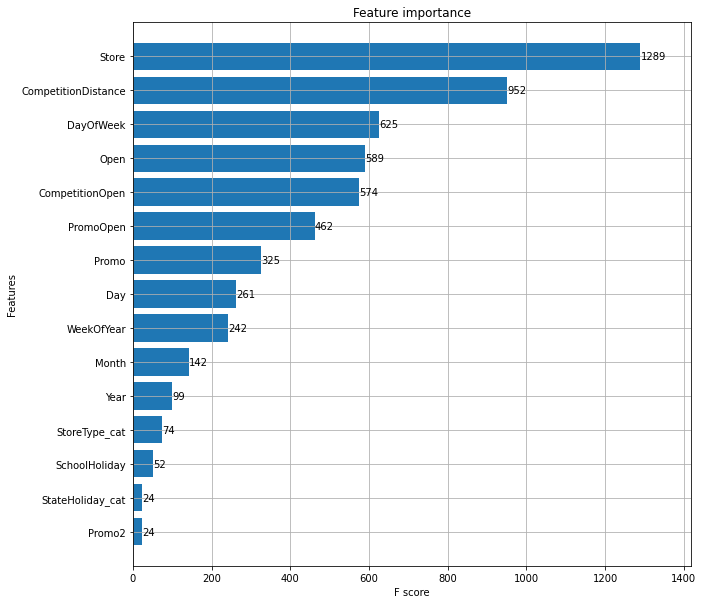

In [32]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost, max_num_features=50, height=0.8, ax=ax)
plt.show()

As expected, there are five major reasons affecting the sales of a store: the number of stores, competition distance, day of the week, is the competition open, and promotions.
